## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

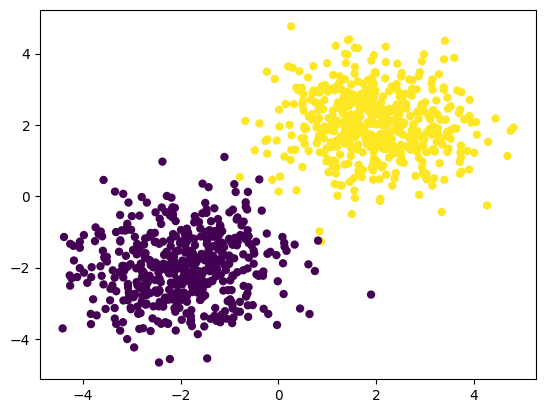

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

In [4]:
model = Sequential()
model.add(Linear(2, 10))
model.add(ReLU())
model.add(Linear(10, 2))   # 2 выхода под два класса (one-hot Y)
criterion = MSECriterion()

In [5]:
output = model.forward(X)
loss = criterion.forward(output, Y)
print(loss)

2.7315206462309614


In [6]:
grad_loss = criterion.backward(output, Y)
grad_loss

array([[-0.00245266, -0.00231156],
       [-0.00212478, -0.00147757],
       [-0.00159133, -0.00345603],
       ...,
       [-0.0008132 , -0.00291709],
       [-0.00136645, -0.00330707],
       [-0.00081322, -0.00290246]], shape=(1000, 2))

In [7]:
model.backward(X, grad_loss)

array([[ 1.06173782e-05,  1.15346278e-03],
       [ 3.79476172e-04,  1.03985151e-04],
       [ 5.87588642e-04,  1.62355385e-03],
       ...,
       [-2.23078465e-04, -1.59885749e-04],
       [-8.78318650e-04,  6.00706070e-04],
       [-2.22560473e-04, -1.58805107e-04]], shape=(1000, 2))

Define a **logistic regression** for debugging. 

In [8]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [9]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [10]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [11]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

Current loss: 0.007638


# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [12]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [13]:
# Your code goes here. ################################################

num_classes = 10

def to_one_hot(y, num_classes=10):
    return np.eye(num_classes, dtype=np.float32)[y]

y_train_oh = to_one_hot(y_train, num_classes)
y_val_oh   = to_one_hot(y_val, num_classes)
y_test_oh  = to_one_hot(y_test, num_classes)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [14]:
# Your code goes here. ################################################
import matplotlib.pyplot as plt

np.random.seed(42)

def make_mlp(activation_module, use_batchnorm=False, hidden_size=128):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(28*28, hidden_size))
    if use_batchnorm:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(hidden_size))
    net.add(activation_module)
    net.add(Linear(hidden_size, num_classes))
    net.add(LogSoftMax())
    return net


def train_model(model, optimizer_name='adam',
                num_epochs=15, batch_size=128, lr=1e-3,
                verbose=True):
    criterion = ClassNLLCriterion()
    N = X_train.shape[0]
    train_losses = []
    state = {}

    for epoch in range(num_epochs):
        model.train()
        indices = np.random.permutation(N)

        epoch_loss = 0.0
        n_batches = 0

        for start in range(0, N, batch_size):
            batch_idx = indices[start:start+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train_oh[batch_idx]

            out = model.forward(X_batch)
            loss = criterion.forward(out, y_batch)

            epoch_loss += loss
            n_batches += 1

            model.zeroGradParameters()

            dloss = criterion.backward(out, y_batch)
            model.backward(X_batch, dloss)

            variables = model.getParameters()
            gradients = model.getGradParameters()

            if optimizer_name == 'sgd':
                sgd_momentum(
                    variables, gradients,
                    config={'learning_rate': lr, 'momentum': 0.9},
                    state=state
                )
            elif optimizer_name == 'adam':
                adam_optimizer(
                    variables, gradients,
                    config={
                        'learning_rate': lr,
                        'beta1': 0.9,
                        'beta2': 0.999,
                        'epsilon': 1e-8
                    },
                    state=state
                )
            else:
                raise ValueError("Unknown optimizer: " + optimizer_name)

        avg_train_loss = epoch_loss / n_batches
        train_losses.append(avg_train_loss)

        model.evaluate()
        val_out = model.forward(X_val)
        val_loss = criterion.forward(val_out, y_val_oh)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} "
                  f"train_loss={avg_train_loss:.4f}  val_loss={val_loss:.4f}")

    return train_losses


=== Training with activation: ReLU (no BatchNorm) ===
Epoch 1/15 train_loss=0.4551  val_loss=0.2351
Epoch 2/15 train_loss=0.2180  val_loss=0.1729
Epoch 3/15 train_loss=0.1633  val_loss=0.1405
Epoch 4/15 train_loss=0.1273  val_loss=0.1270
Epoch 5/15 train_loss=0.1028  val_loss=0.1141
Epoch 6/15 train_loss=0.0847  val_loss=0.1029
Epoch 7/15 train_loss=0.0732  val_loss=0.0970
Epoch 8/15 train_loss=0.0615  val_loss=0.0879
Epoch 9/15 train_loss=0.0528  val_loss=0.0855
Epoch 10/15 train_loss=0.0451  val_loss=0.0831
Epoch 11/15 train_loss=0.0385  val_loss=0.0866
Epoch 12/15 train_loss=0.0337  val_loss=0.0807
Epoch 13/15 train_loss=0.0289  val_loss=0.0809
Epoch 14/15 train_loss=0.0251  val_loss=0.0811
Epoch 15/15 train_loss=0.0207  val_loss=0.0811

=== Training with activation: ELU (no BatchNorm) ===
Epoch 1/15 train_loss=0.4519  val_loss=0.2648
Epoch 2/15 train_loss=0.2522  val_loss=0.2023
Epoch 3/15 train_loss=0.1895  val_loss=0.1640
Epoch 4/15 train_loss=0.1486  val_loss=0.1350
Epoch 5/15 

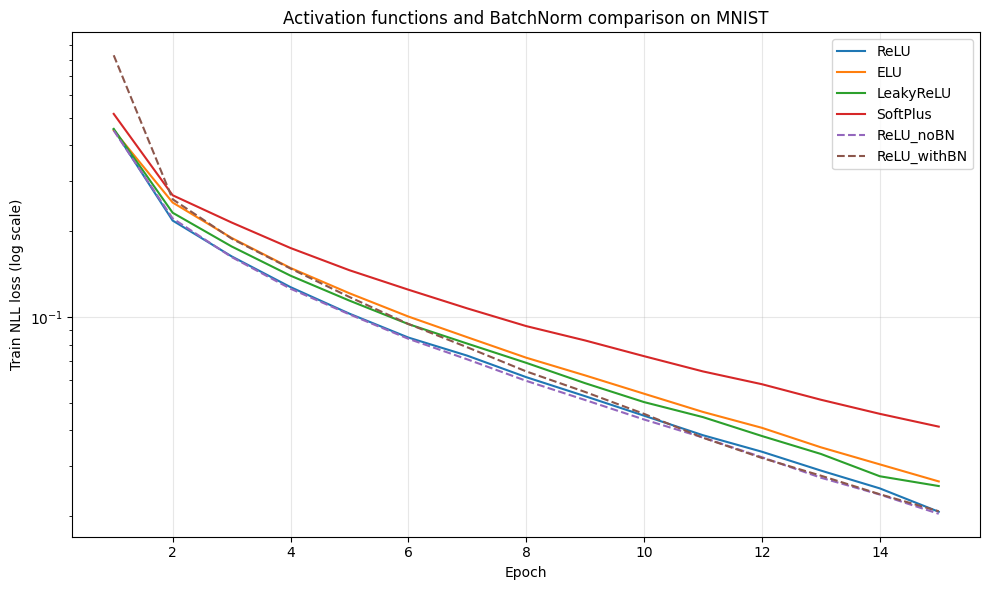

In [15]:
num_epochs = 15
batch_size = 128

act_configs = {
    "ReLU":      ReLU(),
    "ELU":       ELU(alpha=1.0),
    "LeakyReLU": LeakyReLU(slope=0.1),
    "SoftPlus":  SoftPlus()
}

activation_losses = {}

for name, act in act_configs.items():
    print(f"\n=== Training with activation: {name} (no BatchNorm) ===")
    model = make_mlp(act, use_batchnorm=False, hidden_size=128)
    losses = train_model(model,
                         optimizer_name='adam',
                         num_epochs=num_epochs,
                         batch_size=batch_size,
                         lr=1e-3)
    activation_losses[name] = losses

bn_losses = {}

print("\n=== ReLU WITHOUT BatchNorm (again, for fair comparison) ===")
model_relu = make_mlp(ReLU(), use_batchnorm=False, hidden_size=128)
bn_losses["ReLU_noBN"] = train_model(model_relu,
                                     optimizer_name='adam',
                                     num_epochs=num_epochs,
                                     batch_size=batch_size,
                                     lr=1e-3)

print("\n=== ReLU WITH BatchNorm+ChannelwiseScaling ===")
model_relu_bn = make_mlp(ReLU(), use_batchnorm=True, hidden_size=128)
bn_losses["ReLU_withBN"] = train_model(model_relu_bn,
                                       optimizer_name='adam',
                                       num_epochs=num_epochs,
                                       batch_size=batch_size,
                                       lr=1e-3)

plt.figure(figsize=(10, 6))

for name, losses in activation_losses.items():
    plt.plot(range(1, num_epochs+1), losses, label=name)

for name, losses in bn_losses.items():
    plt.plot(range(1, num_epochs+1), losses, '--', label=name)

plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Train NLL loss (log scale)')
plt.title('Activation functions and BatchNorm comparison on MNIST')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


=== Optimizer: SGD + momentum ===
Epoch 1/15 train_loss=0.3957  val_loss=0.1481
Epoch 2/15 train_loss=0.1322  val_loss=0.1049
Epoch 3/15 train_loss=0.0918  val_loss=0.1058
Epoch 4/15 train_loss=0.0707  val_loss=0.0839
Epoch 5/15 train_loss=0.0550  val_loss=0.0806
Epoch 6/15 train_loss=0.0454  val_loss=0.0822
Epoch 7/15 train_loss=0.0375  val_loss=0.0811
Epoch 8/15 train_loss=0.0317  val_loss=0.0797
Epoch 9/15 train_loss=0.0249  val_loss=0.0833
Epoch 10/15 train_loss=0.0218  val_loss=0.0826
Epoch 11/15 train_loss=0.0170  val_loss=0.0835
Epoch 12/15 train_loss=0.0157  val_loss=0.0850
Epoch 13/15 train_loss=0.0131  val_loss=0.0891
Epoch 14/15 train_loss=0.0122  val_loss=0.0857
Epoch 15/15 train_loss=0.0092  val_loss=0.0852

=== Optimizer: Adam ===
Epoch 1/15 train_loss=0.8205  val_loss=0.2785
Epoch 2/15 train_loss=0.2547  val_loss=0.1958
Epoch 3/15 train_loss=0.1827  val_loss=0.1528
Epoch 4/15 train_loss=0.1383  val_loss=0.1313
Epoch 5/15 train_loss=0.1108  val_loss=0.1150
Epoch 6/15 tra

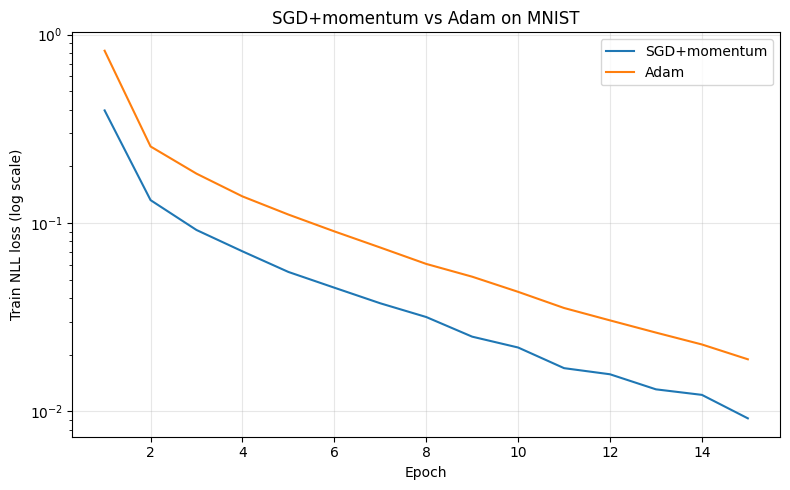

In [16]:
num_epochs_opt = 15
batch_size = 128

print("\n=== Optimizer: SGD + momentum ===")
model_sgd = make_mlp(ReLU(), use_batchnorm=True, hidden_size=128)
sgd_losses = train_model(model_sgd,
                         optimizer_name='sgd',
                         num_epochs=num_epochs_opt,
                         batch_size=batch_size,
                         lr=0.1)  # для SGD можно взять побольше lr

print("\n=== Optimizer: Adam ===")
model_adam = make_mlp(ReLU(), use_batchnorm=True, hidden_size=128)
adam_losses = train_model(model_adam,
                          optimizer_name='adam',
                          num_epochs=num_epochs_opt,
                          batch_size=batch_size,
                          lr=1e-3)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs_opt+1), sgd_losses, label='SGD+momentum')
plt.plot(range(1, num_epochs_opt+1), adam_losses, label='Adam')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Train NLL loss (log scale)')
plt.title('SGD+momentum vs Adam on MNIST')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

### Short notes on activation functions (based on our experiment)

**ReLU**
- `f(x) = max(0, x)`
- Very cheap to compute, simple gradient.
- Works well “out of the box” on MNIST and many other tasks.
- Main drawback: possible “dead ReLUs” (neurons stuck at zero), but in small nets это почти не проблема.
- ✔ Good default choice.

**LeakyReLU**
- `f(x) = x` if `x > 0`, `αx` otherwise (e.g. `α = 0.01` or `0.1`).
- Computation cost ≈ ReLU (одна max + одно умножение).
- Keeps non-zero gradient for negative inputs → меньше «умирающих» нейронов.
- В экспериментах даёт кривую loss очень близкую к ReLU (иногда чуть лучше).
- ✔ Хороший безопасный вариант вместо ReLU.

**ELU**
- `f(x) = x` if `x > 0`, `α (exp(x) − 1)` otherwise.
- Требует `exp` → дороже по времени, чем ReLU/LeakyReLU.
- Делает активации более центрированными вокруг нуля, теоретически помогает обучению глубоких сетей.
- В нашей небольшой MLP на MNIST не даёт заметного выигрыша над ReLU/LeakyReLU.
- ✔ Имеет смысл пробовать в более глубоких/сложных моделях.

**SoftPlus**
- `f(x) = log(1 + exp(x))` — гладкая версия ReLU.
- Самая тяжёлая по вычислениям: и `exp`, и `log` в forward + `exp` в backward.
- В отрицательной области сильно сглаживает градиент → обучение идёт медленнее.
- В экспериментах даёт существенно более высокую loss, чем остальные функции.
- ✖ Обычно не используют как основную активацию в простых моделях.

**BatchNormalization (+ ChannelwiseScaling)**
- Нормализует активации внутри батча и обучает линейное масштабирование/сдвиг.
- Даёт чуть более быструю и стабильную сходимость; в наших экспериментах ReLU+BN даёт минимальный train loss.
- В такой маленькой сети выигрыш умеренный, но в глубоких сетях BN почти всегда полезен.
**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [17]:
# Your code goes here. ################################################

In [18]:
X_train_cnn = X_train.reshape(-1, 1, 28, 28)
X_val_cnn   = X_val.reshape(-1, 1, 28, 28)
X_test_cnn  = X_test.reshape(-1, 1, 28, 28)

In [19]:
from scipy.ndimage import rotate

def random_shift_batch(batch, max_shift=2):
    N, C, H, W = batch.shape
    assert C == 1
    padded = np.pad(batch,
                    ((0, 0), (0, 0),
                     (max_shift, max_shift),
                     (max_shift, max_shift)),
                    mode='constant')
    shifted = np.empty_like(batch)
    for i in range(N):
        dx = np.random.randint(-max_shift, max_shift + 1)
        dy = np.random.randint(-max_shift, max_shift + 1)
        x0 = max_shift + dx
        y0 = max_shift + dy
        shifted[i, 0] = padded[i, 0, x0:x0+H, y0:y0+W]
    return shifted


def random_rotate_batch(batch, max_angle=15, p=0.5):
    N, C, H, W = batch.shape
    rotated = batch.copy()
    for i in range(N):
        if np.random.rand() < p:
            angle = np.random.uniform(-max_angle, max_angle)
            img = rotate(batch[i, 0], angle,
                         reshape=False,
                         order=1,
                         mode='constant',
                         cval=0.0)
            rotated[i, 0] = img
    return rotated


def augment_batch(batch):
    """Комбинируем сдвиги и повороты."""
    # batch_aug = random_shift_batch(batch, max_shift=2)
    # batch_aug = random_rotate_batch(batch_aug, max_angle=15, p=0.5)
    return batch


In [20]:
def build_super_model():
    model = Sequential()

    # Блок 1 (сверточный)
    model.add(Conv2d(1, 16, kernel_size=3))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2))
    model.add(Dropout(p=0.25))

    # Блок 2 (сверточный)
    model.add(Conv2d(16, 32, kernel_size=3))
    model.add(ReLU())
    model.add(MaxPool2d(kernel_size=2))
    model.add(Dropout(p=0.25))

    model.add(Flatten())

    # Полносвязный блок
    model.add(Linear(32 * 7 * 7, 256))
    model.add(BatchNormalization(alpha=0.9))
    model.add(ChannelwiseScaling(256))
    model.add(ReLU())
    model.add(Dropout(p=0.5))

    model.add(Linear(256, 10))
    model.add(LogSoftMax())

    return model


In [24]:
def train_super_model(num_epochs=20,
                      base_lr=1e-3,
                      lr_decay=0.9,
                      batch_size=128,
                      verbose=True):
    model = build_super_model()
    criterion = ClassNLLCriterion()
    N = X_train_cnn.shape[0]

    state = {}
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        lr = base_lr * (lr_decay ** epoch)

        model.train()
        indices = np.random.permutation(N)

        epoch_loss = 0.0
        n_batches = 0
        for start in range(0, N, batch_size):
            batch_idx = indices[start:start + batch_size]
            X_batch = X_train_cnn[batch_idx]
            y_batch = y_train_oh[batch_idx]

            X_batch_aug = augment_batch(X_batch)

            out = model.forward(X_batch_aug)
            loss = criterion.forward(out, y_batch)
            epoch_loss += loss
            n_batches += 1

            model.zeroGradParameters()
            dloss = criterion.backward(out, y_batch)
            model.backward(X_batch_aug, dloss)

            variables = model.getParameters()
            gradients = model.getGradParameters()
            adam_optimizer(
                variables, gradients,
                config={
                    'learning_rate': lr,
                    'beta1': 0.9,
                    'beta2': 0.999,
                    'epsilon': 1e-8
                },
                state=state
            )

        avg_train_loss = epoch_loss / n_batches
        train_losses.append(avg_train_loss)

        model.evaluate()
        val_out = model.forward(X_val_cnn)
        val_loss = criterion.forward(val_out, y_val_oh)
        val_losses.append(val_loss)

        preds = np.argmax(val_out, axis=1)
        val_acc = (preds == y_val).mean()
        val_accs.append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1:02d}/{num_epochs}  "
                  f"lr={lr:.5f}  "
                  f"train_loss={avg_train_loss:.4f}  "
                  f"val_loss={val_loss:.4f}  "
                  f"val_acc={val_acc*100:.2f}%")

    return model, train_losses, val_losses, val_accs


In [27]:
super_model, tr_losses, val_losses, val_accs = train_super_model(
    num_epochs=5,
    base_lr=1e-3,
    lr_decay=0.95,
    batch_size=128,
    verbose=True
)

super_model.evaluate()
test_out = super_model.forward(X_test_cnn)
test_preds = np.argmax(test_out, axis=1)
test_acc = (test_preds == y_test).mean()
print(f"Test accuracy: {test_acc * 100:.2f}%")


Epoch 01/5  lr=0.00100  train_loss=0.6130  val_loss=0.0828  val_acc=98.16%
Epoch 02/5  lr=0.00095  train_loss=0.1151  val_loss=0.0509  val_acc=98.61%
Epoch 03/5  lr=0.00090  train_loss=0.0882  val_loss=0.0436  val_acc=98.79%
Epoch 04/5  lr=0.00086  train_loss=0.0755  val_loss=0.0392  val_acc=98.82%
Epoch 05/5  lr=0.00081  train_loss=0.0669  val_loss=0.0361  val_acc=98.93%
Test accuracy: 99.03%


Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [28]:
# Your beautiful code here.
import torch.nn as nn
import torch.optim as optim

In [29]:
class ChannelwiseScaling(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        # x: (N, F)
        return x * self.gamma + self.beta


class SuperConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Блок 1: Conv2d(1->16, 3x3) + ReLU + MaxPool2d(2) + Dropout(0.25)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # padding=1, чтобы сохранить 28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            nn.Dropout(p=0.25),
        )

        # Блок 2: Conv2d(16->32, 3x3) + ReLU + MaxPool2d(2) + Dropout(0.25)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 7 * 7, 256)

        self.bn1 = nn.BatchNorm1d(256, momentum=0.1)
        self.chan_scale = ChannelwiseScaling(256)
        self.act1 = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # x: (N, 1, 28, 28)
        x = self.block1(x)          # (N, 16, 14, 14)
        x = self.block2(x)          # (N, 32, 7, 7)
        x = self.flatten(x)         # (N, 32*7*7)
        x = self.fc1(x)             # (N, 256)
        x = self.bn1(x)
        x = self.chan_scale(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.fc2(x)             # (N, 10)
        x = self.logsoftmax(x)      # лог-вероятности классов
        return x


In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# X_* : (N, 28, 28) -> (N, 1, 28, 28)
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = SuperConvNet().to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = correct / total * 100.0

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
    test_acc = test_correct / test_total * 100.0

    print(f"Epoch {epoch+1:02d}/{num_epochs} "
          f"train_loss={epoch_loss:.4f} "
          f"train_acc={epoch_acc:.2f}% "
          f"test_acc={test_acc:.2f}%")

print("Training finished.")

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

final_test_acc = test_correct / test_total * 100.0
print(f"Final Test accuracy: {final_test_acc:.2f}%")


Device: cpu
Epoch 01/5 train_loss=0.2884 train_acc=91.58% test_acc=98.10%
Epoch 02/5 train_loss=0.1056 train_acc=96.77% test_acc=98.64%
Epoch 03/5 train_loss=0.0826 train_acc=97.49% test_acc=98.79%
Epoch 04/5 train_loss=0.0708 train_acc=97.76% test_acc=99.05%
Epoch 05/5 train_loss=0.0605 train_acc=98.00% test_acc=98.97%
Training finished.
Final Test accuracy: 98.97%
